# Baby Hayes Activity Plan Scheduler

Welcome to the baby Hayes activity plan scheduler.

This notebook tackles the critical issue of who's turn it is to get out of bed and other parenting nuances.

This notebook requires pam be installed (https://github.com/arup-group/pam) and needs to be run from the project ("spam") root.

Please play with the various parenting params below:

- fairness (who has to get up this time)
- insomnia (sleep quality)
- tiredness (ability to stay awake)

and if you are brave you can modify the transition probabilities for baby Hayes in `data/transitions.xls`. Note that all transition probabilities must be possitive.

In [1]:
import pandas as pd

from pam.core import Household, Person  # pam is a dependancy
from spam import State, BabyMarkovChain, WakeMeUp  # run this notebook on spam root

In [2]:
outpath = "test.png"
fairness = 2  # integers only. 0 is random turns at waking up, 1 and above applies increasing fairness
insomnia = .5  # float between 0 and 1, p of waking
tiredness = .5  # float between 0 and 1, p of falling asleep

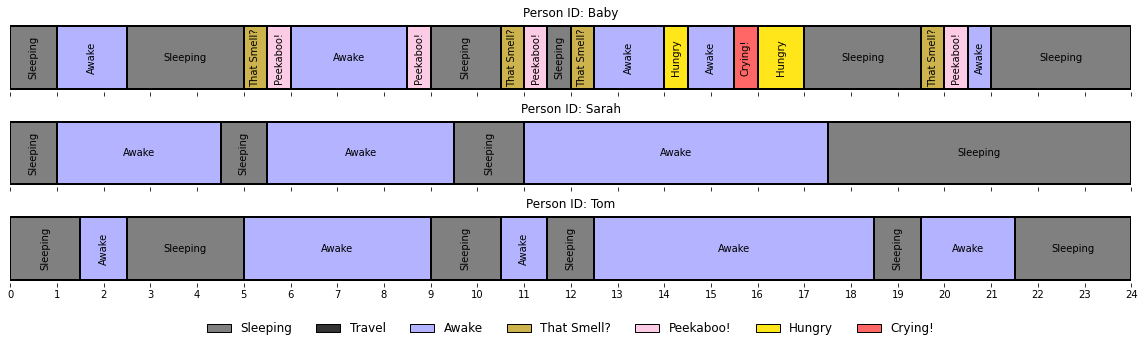

In [22]:
baby, sarah, tom = Person("Baby"), Person("Sarah"), Person("Tom")

hayes = Household("Hayes")
for person in [baby, sarah, tom]:
    hayes.add(person)

baby_state, state_of_sarah, state_of_tom = State(baby), State(sarah), State(tom)

baby_chain = BabyMarkovChain(
    step_size=30  # some possitive multiple of 15 (minutes), 30 preferred
)
baby_state.seed_state(baby_chain.initial_state)

parental_states = WakeMeUp(
    units=[state_of_sarah, state_of_tom],
    initial=baby_chain.initial_state,
    fairness=fairness,
    insomnia=insomnia,
    tiredness=tiredness
)

for time, state in baby_chain.step():
    baby_state.update(time, state)
    parental_states.update(time, state)
    
for state in [baby_state, state_of_sarah, state_of_tom]:
    state.close()
    
hayes.plot(
    cmap={
        'Sleeping': (0.5, 0.5, 0.5),  # grey
        'Travel': (0.2, 0.2, 0.2),  # dark grey
        'Awake': (.7, 0.7, 1.),  # yellow
        'That Smell?': (0.8, 0.7, 0.3),  # brownish
        'Peekaboo!': (0.99, 0.8, 0.9),  # pink
        'Hungry': (1., .9, .1),  # blue
        'Crying!': (1.0, .4, .4)  # red
        },
    path=outpath
)
    

# Optional Analysis

In [23]:
def assess_plan(person):
    summary = {}
    act_types = set([act.act for act in list(person.activities)])
    for act_type in act_types:
        count, duration = assess_act(person, act_type)
        summary[f"{act_type}_count"] = count
        summary[f"{act_type}_duration"] = duration / 3600
        summary[f"{act_type}_av_duration"] = duration / count / 3600
    return summary
    
def assess_act(person, act_type):
    durations = []
    for act in list(person.activities):
        if act.act == act_type:
            durations.append(act.duration.total_seconds())
    return len(durations), sum(durations)
    
def assess(units):
    summary = {}
    for unit in units:
        summary[unit.pid] = assess_plan(unit)
    return pd.DataFrame(summary).T

In [24]:
analysis_days = 7

In [25]:
all_days = []

for day in range(analysis_days):
    baby, sarah, tom = Person("Baby"), Person("Sarah"), Person("Tom")

    hayes = Household("Hayes")
    for person in [baby, sarah, tom]:
        hayes.add(person)

    baby_state, state_of_sarah, state_of_tom = State(baby), State(sarah), State(tom)

    baby_chain = BabyMarkovChain(
        step_size=30  # some possitive multiple of 15 (minutes)
    )
    baby_state.seed_state(baby_chain.initial_state)

    parental_states = WakeMeUp(
        units=[state_of_sarah, state_of_tom],
        initial=baby_chain.initial_state,
        fairness=fairness,
        insomnia=insomnia,
        tiredness=tiredness
    )

    for time, state in baby_chain.step():
        baby_state.update(time, state)
        parental_states.update(time, state)

    for state in [baby_state, state_of_sarah, state_of_tom]:
        state.close()
        
    df = assess([sarah, tom])
    all_days.append(df)

In [26]:
results = pd.concat(all_days)
results.groupby(results.index).agg(
    {
        "awake_count":"sum",
        "awake_duration":"sum",
        "awake_av_duration":"mean",
        "sleeping_count":"sum",
        "sleeping_duration":"sum",
        "sleeping_av_duration":"mean",
    })

,awake_count,awake_duration,awake_av_duration,sleeping_count,sleeping_duration,sleeping_av_duration
Sarah,26.0,109.5,5.159524,24.0,58.5,2.485714
Tom,26.0,100.5,4.000000,26.0,67.5,2.657143
